In [13]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")


# Determine the optimal number of threads for this setup

Restart and run these cells with different 'set_num_threads' values. On my mac these values are:   

- the number of cpu threads: 2, time: 0.67
- the number of cpu threads: 3, time: 0.58
- the number of cpu threads: 4, time: 0.59
- the number of cpu threads: 5, time: 0.60
- the number of cpu threads: 10, time: 0.74

In [3]:
torch.set_num_threads(4) # This is the 

INDEX = 10000
NELE = 1000

a = torch.rand(INDEX, NELE)
index = np.random.randint(INDEX-1, size=INDEX*8)
b = torch.from_numpy(index)

start = time.time()
for _ in range(10):
    res = a.index_select(0, b)
print("the number of cpu threads: {}, time: {:4.2f}".format(torch.get_num_threads(), time.time()-start))


the number of cpu threads: 4, time: 0.59


Download and inspect the data

In [4]:
from deeptime.data import sqrt_model

dtraj, traj = sqrt_model(n_samples=10000)

In [5]:
np.unique(dtraj, return_counts=True)

(array([0, 1], dtype=int32), array([4871, 5129]))

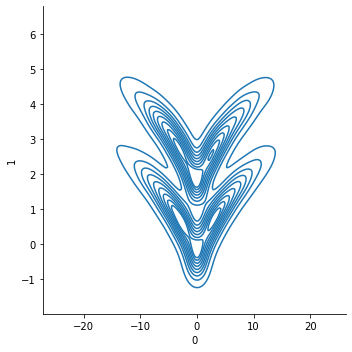

In [6]:
sns.displot(pd.DataFrame(traj), x=0, y=1, kind='kde')

Split data

In [7]:
from deeptime.util.data import TrajectoryDataset

lag = 1
val_frac = 0.3
dataset = TrajectoryDataset(lag, traj.astype(np.float32))

n_val = int(len(dataset)*val_frac)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset) - n_val, n_val])


Set-up model

In [8]:
from deeptime.util.torch import MLP
lobe = MLP(units=[traj.shape[1], 15, 10, 10, 5, 1], nonlinearity=nn.ReLU)
lobe = lobe.to(device=device)

In [9]:
from deeptime.decomposition.deep import VAMPNet

vampnet = VAMPNet(lobe=lobe, learning_rate=1e-3, device=device)

In [10]:
from torch.utils.data import DataLoader

loader_train = DataLoader(train_data, batch_size=512, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)



In [11]:
from tqdm.notebook import tqdm
model = vampnet.fit(loader_train, n_epochs=80,
                    validation_loader=loader_val, progress=tqdm).fetch_model()



VAMPNet epoch:   0%|          | 0/80 [00:00<?, ?it/s]

/Users/robertarbon/opt/miniconda3/envs/vampnets/lib/python3.8/site-packages/deeptime/decomposition/deep/_vampnet.py:42: UserWarning: torch.symeig is deprecated in favor of torch.linalg.eigh and will be removed in a future PyTorch release.
The default behavior has changed from using the upper triangular portion of the matrix by default to using the lower triangular portion.
L, _ = torch.symeig(A, upper=upper)
should be replaced with
L = torch.linalg.eigvalsh(A, UPLO='U' if upper else 'L')
and
L, V = torch.symeig(A, eigenvectors=True)
should be replaced with
L, V = torch.linalg.eigh(A, UPLO='U' if upper else 'L') (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1631631227379/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2500.)
  eigval, eigvec = torch.symeig(mat, eigenvectors=True)
/Users/robertarbon/opt/miniconda3/envs/vampnets/lib/python3.8/site-packages/torch/functional.py:1403: UserWarning: torch.chain_matmul is deprecated and will be removed in a future 

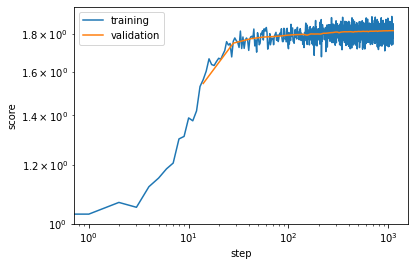

In [14]:
plt.loglog(*vampnet.train_scores.T, label='training')
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('step')
plt.ylabel('score')
plt.legend();

